In [1]:
%store -r __import

In [2]:
__import

In [3]:
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [4]:
def impute_median_sex_age_fare(df):
    male_passangers = df[df['Sex'] == 'male']
    female_passangers = df[df['Sex'] == 'female']
    male_passangers.Age.fillna(male_passangers.Age.median(), inplace=True)
    female_passangers.Age.fillna(female_passangers.Age.median(), inplace=True)
    new_df = pd.concat([male_passangers, female_passangers])
    new_df.Fare.fillna(new_df.Fare.median(), inplace=True)
    return new_df.sample(frac=1, random_state=42)

def impute_mode_embarked(df):
    df.Embarked.fillna('S', inplace=True)
    return df
    
def create_new_features(df):
    df['isincabin'] = df['Cabin'].notna().astype('int')
    df['is_underage'] = (df.Age < 18).astype('int')
    df['is_midlife'] = ((df.Age > 18) & (df.Age < 60)).astype('int')
    df['is_elder'] = (df.Age > 60).astype('int')
    df['name_len'] = df.Name.apply(lambda x: len(x))
    df['ticket_len'] = df.Ticket.apply(lambda x: len(x))
    df['price_len'] = df.Fare.astype('str').apply(lambda x: len(x))
    df = pd.concat([df, pd.get_dummies(df.Sex)], axis=1)
    df = pd.concat([df, pd.get_dummies(df.Embarked)], axis=1)
    df = pd.concat([df, pd.get_dummies(df.Pclass)], axis=1)
    df.drop(['Sex'], axis=1, inplace=True)
    df.drop(['Embarked'], axis=1, inplace=True)
    df.drop(['Pclass'], axis=1, inplace=True)
    return df

def print_feature_importances(model, cols):
    features = cols
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance');
    
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [5]:
train = pd.read_csv('/home/tuts/datasets/titanic/train.csv')
test = pd.read_csv('/home/tuts/datasets/titanic/test.csv')

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_test = pd.concat([train, test])
train_test = impute_median_sex_age_fare(train_test)
train_test = impute_mode_embarked(train_test)
train_test = create_new_features(train_test)

In [16]:
# train_test.Cabin.isna().astype('int')

0      1
1      0
2      1
3      0
4      1
      ..
413    1
414    0
415    1
416    1
417    1
Name: Cabin, Length: 1309, dtype: int64

In [22]:
train_test.Age.median()

28.0

In [21]:
train_test[['Pclass', 'Sex', 'Age']].groupby(['Pclass', 'Sex']).median()

Age
Pclass Sex         
1      female  36.0
       male    42.0
2      female  28.0
       male    29.5
3      female  22.0
       male    25.0

In [7]:
baseline_cols = [1, 2, 'C', 'Q', 'Age', 'female', 'SibSp', 'Parch', 'Fare', 'isincabin', 'is_underage', 'is_midlife']

X = train_test[train_test['Survived'].notna()][baseline_cols]
y = train_test[train_test['Survived'].notna()]['Survived']

In [8]:
parameters = {
    'max_depth': list(range(5,10)),
    'min_samples_leaf': list(range(1,11)),
    'max_leaf_nodes': list(range(2, 15))
}

grid_rf = RandomForestClassifier(n_jobs=-1)
gs = GridSearchCV(grid_rf, parameters, scoring='accuracy', cv=5, )

In [9]:
gs.fit(X.values, y.values)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [5, 6, 7, 8, 9],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

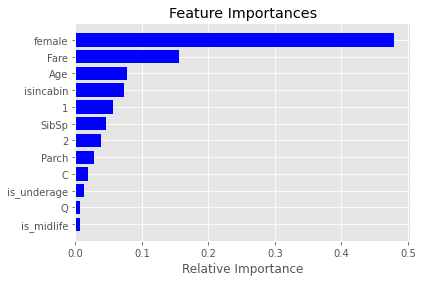

In [10]:
be = gs.best_estimator_
print_feature_importances(be, baseline_cols)

In [22]:
be

RandomForestClassifier(max_depth=6, max_leaf_nodes=13, min_samples_leaf=3,
                       n_estimators=300, n_jobs=-1)

In [46]:
rf = RandomForestClassifier(max_depth=6, max_leaf_nodes=13, min_samples_leaf=3, n_estimators=350, n_jobs=-1)
cross_val_score(rf, X, y, cv=10, scoring='accuracy', n_jobs=-1)

array([0.78888889, 0.83146067, 0.80898876, 0.7752809 , 0.83146067,
       0.82022472, 0.84269663, 0.87640449, 0.83146067, 0.75280899])

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_leaf_nodes=13, min_samples_leaf=3,
                       n_estimators=350, n_jobs=-1)

In [49]:
y_hat = rf.predict(X_val)
accuracy_score(y_val, y_hat)

0.8283582089552238

In [54]:
model = be

In [51]:
gs_results = pd.DataFrame(gs.cv_results_)
# scores = np.array(gs_results.mean_test_score).reshape(len(parameters['max_depth']), len(parameters['max_leaf_nodes']))
# plt.figure(figsize=(10,10))
# heatmap(scores, xlabel='max_leaf_nodes', xticklabels=parameters['max_leaf_nodes'],
# ylabel='max_depth', yticklabels=parameters['max_depth'], cmap="viridis");

In [52]:
X_test = train_test[train_test['Survived'].isna()][baseline_cols]
X_test_ordered = X_test.sort_index()
submission = model.predict(X_test_ordered)
submission = pd.DataFrame(data={'PassengerId': np.array(range(418))+892, 'Survived': submission.astype('int')})

In [53]:
submission.to_csv(f'submission_{datetime.now().strftime("%d%m%Y%H:%M:%S")}.csv', index=False)